In [1]:
import pandas as pd 
import numpy as np
from numpy import loadtxt
import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import shap

[[26268.8 3027.0 46 1.691160221]
 [18512.5 3273.0 49 1.817679558]
 [23285.0 1990.0 7 1.104972376]
 [27628.5 3491.0 53 1.93480663]
 [29661.5 4043.5 64 2.256906077]
 [25134.8 3295.5 41 1.827624309]
 [19989.2 2539.5 13 1.409392265]
 [28449.6 3145.0 37 1.751381215]
 [20883.6 3823.5 73 2.12320442]
 [31003.7 2674.5 20 1.493922652]
 [23880.0 2199.5 14 1.221546961]
 [31097.6 2680.0 31 1.490607735]
 [26172.5 2795.0 32 1.549723757]
 [23078.4 3054.5 32 1.693370166]
 [22623.0 2039.0 13 1.138674033]
 [24925.6 1974.0 7 1.100552486]
 [25977.5 3586.0 66 1.987845304]
 [26186.1 2694.5 32 1.495027624]
 [26935.0 2140.0 17 1.191712707]
 [24282.5 3021.5 48 1.679558011]
 [20802.8 3563.5 75 1.980110497]]
MAPE: 0.5066467625431691
RMSE: 20.98124190870177
RMSRE: 0.650726322717071


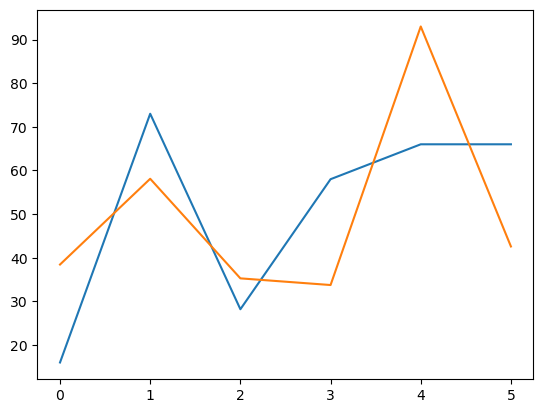

In [2]:
#load data
dataset = pd.read_csv("C:\\Users\\namil\\Downloads\\002data.csv").dropna().to_numpy()
selected_inputs = range(3,7,1)
X = dataset[:,selected_inputs]
Y = dataset[:,8]
print(X)

#split into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#make model
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

#package error calculations
mape = MAPE(y_test, prediction)
print("MAPE:", mape)
mse = MSE(y_test, prediction)
rmse = mse**0.5
print("RMSE:", rmse)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)

RMSRE: 0.4043537088515378


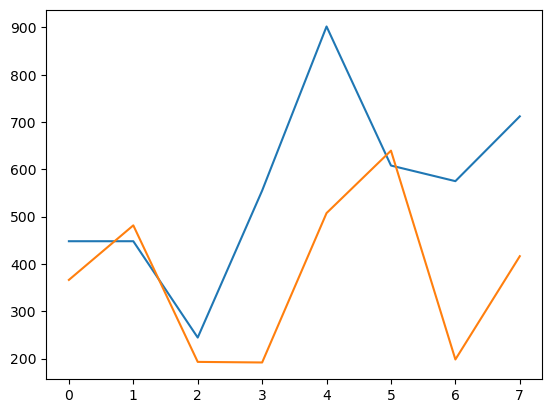

In [3]:
selected_inputs = range(9,13,1)
output = 'calories'


test = pd.read_csv("C:\\Users\\namil\\Documents\\stmi-lab-namila\\allmetrics3")
valid = test[test['dexcom 3hr auc'] != "error"]
X = valid.iloc[:, selected_inputs].to_numpy()
Y = valid[output].to_numpy()

#split into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#make model
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)

In [4]:
#function to make and evaluate model w selected inputs/outputs
def basemodel(participant, arr, start, end, topredict, removesnacks, nodinners):

    #read in fine
    #test = pd.read_csv(f"C:\\Users\\namil\\Documents\\stmi-lab-namila\\allmetricsn{participant}")
    test = pd.read_csv(f"C:\\Users\\namil\\Documents\\stmi-lab-namila\\combined_dataset")
    
    #remove meals if needed (and invalid meals)
    if nodinners:
        test = test[test['Meal Type'] != "dinner"] 
    if removesnacks:
        test = test[test['snack in 3hrs'] == False]

    valid = test[test['dexcom 3hr auc'] != "error"]
    valid = valid[valid['mets 3 hr auc'] != "error"]
    
    #X and Y datasets
    X = valid.loc[:, start:end].to_numpy().astype(float)
    Y = valid[topredict].to_numpy().astype(float)
    warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    #split into train and test sets
    seed = 7
    test_size = 0.25
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    #make model
    model = XGBRegressor()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

#     plt.plot(y_test)
#     plt.plot(prediction)
#     plt.show()
    
    print(f"predicting {topredict} from {start} to {end}")
    
    #calculate normalized rmse
    np.seterr(divide='ignore')
    errors = ((y_test - prediction)/y_test)**2
    rmsre = (np.average(errors))**.5
    arr.append(rmsre)
      
#     # SHAP explainer
#     colnames = np.array(valid.loc[:, start:end].columns.tolist())
#     xdata = pd.DataFrame(data = X_train, columns = colnames)
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(xdata)
#     plt.title(f"predicting {topredict}")
#     shap.summary_plot(shap_values, xdata, plot_type="bar", color="#B9CADF")
    

#runs all combinations of removed meals
def runfour(errors, start, end, topredict):
    global savedval
    savedval = basemodel(x, errors[0], start, end, topredict, 0, 1)
    basemodel(x, errors[1], start, end, topredict, 1, 1)
    savedval = basemodel(x, errors[2], start, end, topredict,  0, 0)
    basemodel(x, errors[3], start, end, topredict, 1, 0)

In [5]:
# participants = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,26,27,28,29]
participants = [1]
inputerrors = [[],[],[],[]]
inputerrors2 = [[],[],[],[]]
predpeakh = [[],[],[],[]]
predauc = [[],[],[],[]]
prediauc = [[],[],[],[]]
predpt = [[],[],[],[]]
predpd = [[],[],[],[]]
sbg = [[],[],[],[]]

for x in participants:
    print(x)
    #predicting macros
    start = 'peakheight'
    end = 'mets 3 hr avg'
    
    runfour(inputerrors, start, end, 'carbs')
    runfour(inputerrors2, start, end, 'calories')
        
    #predicting ppgr
    start = 'mets 3 hr auc'
    end = 'fat'

    runfour(predpeakh, start, end, 'peakheight')
    runfour(predauc, start, end, 'dexcom 3hr auc')
    runfour(prediauc, start, end, 'iauc')
    runfour(predpt, start, end, 'peaktime')
    runfour(predpd, start, end, 'peakduration_40')
    runfour(sbg, start, end, 'startbg')

#export results
df = pd.DataFrame({'participants': participants, 
                  'carbs bl raw rmsre': inputerrors[0], 'carbs bl removed rmsre': inputerrors[1],
                  'carbs bld raw rmsre': inputerrors[2], 'carbs bld removed rmsre': inputerrors[3],
                  'calories bl raw rmsre': inputerrors2[0], 'calories bl removed rmsre': inputerrors2[1],
                  'calories bld raw rmsre': inputerrors2[2], 'calories bld removed rmsre': inputerrors2[3],
                  'ph bl raw rmsre': predpeakh[0], 'ph bl removed rmsre': predpeakh[1],
                  'ph bld raw rmsre': predpeakh[2], 'ph bld removed rmsre': predpeakh[3],
                  'auc bl raw rmsre': predauc[0], 'auc bl removed rmsre': predauc[1],
                  'auc bld raw rmsre': predauc[2], 'auc bld removed rmsre': predauc[3],
                  'iauc bl raw rmsre': prediauc[0], 'iauc bl removed rmsre': prediauc[1],
                  'iauc bld raw rmsre': prediauc[2], 'iauc bld removed rmsre': prediauc[3],
                  'pt bl raw rmsre': predpt[0], 'pt bl removed rmsre': predpt[1],
                  'pt bld raw rmsre': predpt[2], 'pt bld removed rmsre': predpt[3],
                  'pd40 bl raw rmsre': predpd[0], 'pd40 bl removed rmsre': predpd[1],
                  'pd40 bld raw rmsre': predpd[2], 'pd40 bld removed rmsre': predpd[3],
                  'sbg bl raw rmsre': sbg[0], 'sbg bl removed rmsre': sbg[1],
                  'sbg bld raw rmsre': sbg[2], 'sbg bld removed rmsre': sbg[3]
                  })    
    
df.to_csv("untunedcombinedhractivity")

print("done!")

1
predicting carbs from peakheight to mets 3 hr avg
predicting carbs from peakheight to mets 3 hr avg
predicting carbs from peakheight to mets 3 hr avg
predicting carbs from peakheight to mets 3 hr avg
predicting calories from peakheight to mets 3 hr avg
predicting calories from peakheight to mets 3 hr avg
predicting calories from peakheight to mets 3 hr avg
predicting calories from peakheight to mets 3 hr avg
predicting peakheight from mets 3 hr auc to fat
predicting peakheight from mets 3 hr auc to fat
predicting peakheight from mets 3 hr auc to fat
predicting peakheight from mets 3 hr auc to fat
predicting dexcom 3hr auc from mets 3 hr auc to fat
predicting dexcom 3hr auc from mets 3 hr auc to fat
predicting dexcom 3hr auc from mets 3 hr auc to fat
predicting dexcom 3hr auc from mets 3 hr auc to fat
predicting iauc from mets 3 hr auc to fat
predicting iauc from mets 3 hr auc to fat
predicting iauc from mets 3 hr auc to fat
predicting iauc from mets 3 hr auc to fat
predicting peaktim